In [1]:
import numpy as np
import matplotlib.pyplot as plt

from CNN import ThreeLayerConvNet
from model import myModel

from keras.models import Model

import h5py
import time
import pickle
import timeit, os, math

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os
import keras
from keras.datasets import cifar100
from keras.utils import to_categorical

In [3]:
def SoftMax(s):
    # minus max to avoid large s case
    p = np.exp(s-np.expand_dims(np.max(s,axis=1),axis=1))/\
    np.expand_dims(np.exp(s-np.expand_dims(np.max(s,axis=1),axis=1)).sum(axis=1),axis=1)  # matrix of size NxK
    return p

In [4]:
teacher_train_logits = np.load(
    'best_ensemble_logits_100.npz')['arr_0']

In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
(images_train, cls_train), (images_test, cls_test) =  cifar100.load_data()
images_train = images_train.astype('float32')
images_test = images_test.astype('float32')
images_train /= 255
images_test /= 255
n_classes = 100
labels_train = to_categorical(cls_train, n_classes)
labels_test = to_categorical(cls_test, n_classes)

In [7]:
# Prepare data to train with small model
data = {'X_train': images_train.transpose(0,3,1,2).copy(), 'y_train': np.argmax(labels_train,axis=1),
        'X_val': images_test.transpose(0,3,1,2).copy(), 'y_val': np.argmax(labels_test,axis=1),
       }

In [65]:
# temp = [t+1 for t in range(20)]
temp = [25,30,35,40,45,50]
results = {}
for t in temp:
    num_networks=15
    temp=t
    models_s_15 = teacher_train_logits/temp
    softmax_ensemb_models_15 = np.zeros_like(models_s_15)
    for i in range(num_networks):
           softmax_ensemb_models_15[i] = SoftMax(models_s_15[i])
    average_softmax_15 = np.mean(softmax_ensemb_models_15, axis=0)
    
    net_15 = ThreeLayerConvNet(input_dim=(3, 32, 32),num_classes=100,num_filters=16,filter_size=5,hidden_dim=512,
                        reg=0.001,weight_scale=1,dtype=np.float32)
    small_model_15 = myModel(net_15, data,
                          num_epochs=1, batch_size=100,
                          optimizer='adam',
                          optim_config={
                              'learning_rate': 1e-3,},
                          temperature=temp, soft_target=average_softmax_15, distill_mode='proba',
                          verbose=True, print_every=100)
    tic = time.time()
    small_model_15.train()
    toc = time.time()
    print('Execution time: ',toc-tic)
    val_acc = small_model_15.check_accuracy(data['X_val'],data['y_val'])
    print('Test accuracy: {}'.format(val_acc))
    results[temp] =  val_acc
    
    

(Iteration 1 / 500) loss: 1442.086722
(Epoch 0 / 1) train acc: 0.011560; val_acc: 0.011300
(Iteration 101 / 500) loss: 1439.532134
(Iteration 201 / 500) loss: 1439.545030
(Iteration 301 / 500) loss: 1439.022397
(Iteration 401 / 500) loss: 1438.837636
(Epoch 1 / 1) train acc: 0.284000; val_acc: 0.257000
Execution time:  689.5261387825012
Test accuracy: 0.257
(Iteration 1 / 500) loss: 2075.586770
(Epoch 0 / 1) train acc: 0.010120; val_acc: 0.010000
(Iteration 101 / 500) loss: 2073.183427
(Iteration 201 / 500) loss: 2072.743119
(Iteration 301 / 500) loss: 2071.954125
(Iteration 401 / 500) loss: 2072.243606
(Epoch 1 / 1) train acc: 0.245740; val_acc: 0.231700
Execution time:  672.6511619091034
Test accuracy: 0.2317
(Iteration 1 / 500) loss: 2823.934401
(Epoch 0 / 1) train acc: 0.009820; val_acc: 0.010000
(Iteration 101 / 500) loss: 2821.536494
(Iteration 201 / 500) loss: 2821.132117
(Iteration 301 / 500) loss: 2820.420532
(Iteration 401 / 500) loss: 2820.668885
(Epoch 1 / 1) train acc: 0.2

In [64]:
#save results first temperature tests.
np.savez('temp-tests-nonnoise-ensembling-t1-t20', results)

In [111]:
#Getting results non-noise ensemble.
resultst1t20 = np.load('temp-tests-nonnoise-ensembling-t1-t20.npz')['arr_0']
temperaturest1t20= list(resultst1t20.item().keys())
accuraciest1t20 = list(resultst1t20.item().values())
temperaturest25t50 = list(results.keys())
accuracies25t50 = list(results.values())

temp_tested_no_noise_ensembling = temperaturest1t20 + temperaturest25t50
acc_no_noise_ensembling = accuraciest1t20 + accuracies25t50

In [144]:
accuracies_noisy_esemblingt1t20= np.load('accuracies_noisy_esemblingt1t20.npz')['arr_0']
accuracies_noisy_esemblingt1t20 = list(accuracies_noisy_esemblingt1t20)

In [150]:
#Getting results noisy ensembling.
accuracies_noisy_esemblingt1t20= np.load('accuracies_noisy_esemblingt1t20.npz')['arr_0']
accuracies_noisy_esemblingt1t20 = list(accuracies_noisy_esemblingt1t20)
temperatures_noisy_esemblingt1t20 = [i+1 for i in range(20)]
results_noise_introduction = np.load('resultst25t50.npz')['arr_0']
accuracies_noisy_esemblingt25t50 = list(results_noise_introduction.item().values())
temperatures_noisy_esemblingt25t50 = list(results_noise_introduction.item().keys())

temp_tested_no_noise_ensembling
acc_noise_ensembling = accuracies_noisy_esemblingt1t20 + accuracies_noisy_esemblingt25t50
temp_noise_ensembling = temperatures_noisy_esemblingt1t20 + temperatures_noisy_esemblingt25t50

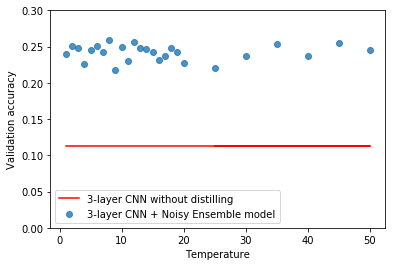

In [152]:
#Student model trained without distilling gave a 11.3% accuracy for 1 epoch  & 1e-3 learning rate 
#with the same parameters we're trainnining the student model.
y = [0.113] * len(list(temp_noise_ensembling))
fig = plt.figure()
plt.scatter(temp_noise_ensembling,acc_noise_ensembling, alpha=0.8, label='3-layer CNN + Noisy Ensemble model')
plt.plot(temp_noise_ensembling, y ,c='red', label='3-layer CNN without distilling')
plt.xlabel("Temperature")
plt.ylabel("Validation accuracy")
plt.legend(loc='best')
plt.ylim(0.0, 0.30)
fig.savefig('distill_cifar100_with-prepro.pdf')
plt.show()

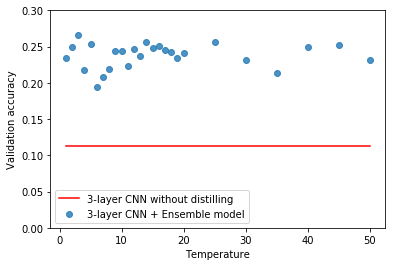

In [125]:
#Student model trained without distilling gave a 11.3% accuracy for 1 epoch  & 1e-3 learning rate 
#with the same parameters we're trainnining the student model.
y = [0.113] * len(list(temp_tested_no_noise_ensembling))
fig = plt.figure()
plt.scatter(temp_tested_no_noise_ensembling, acc_no_noise_ensembling, alpha=0.8, label='3-layer CNN + Ensemble model')
plt.plot(list(temp_tested_no_noise_ensembling), y ,c='red', label='3-layer CNN without distilling')
plt.xlabel("Temperature")
plt.ylabel("Validation accuracy")
plt.legend(loc='best')
plt.ylim(0.0, 0.30)
fig.savefig('distill_cifar100_without-prepro.pdf')
plt.show()